## Part I: CNN for handwritten digit recognition
### Introduction:

- In this section, you'll implement a CNN model and training loop with Pytorch to predict the category of the handwritten digit image.
- In this experiment, we use the MNIST dataset, a image dataset including digit from 0 to 9, with a training set of 60,000 examples, and a test set of 10,000 examples.

### Task:
- You need to design the model and complete the training loop with Pytorch.
- You need to achieve at least 90% averaged Top1 Acc on test data.
- You need to download the data files mnist_train.csv and mnist_test.csv from the following links:

    mnist_train.csv https://www.dropbox.com/s/gm82o0atvvpwc0f/mnist_train.csv?dl=0
    
    mnist_test.csv https://www.dropbox.com/s/jm1bz8rtp0ecfw1/mnist_test.csv?dl=0
    
  and place those files in the same folder with ipynb files.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls '/content/drive/MyDrive/Colab Notebooks/mnist_test.csv'

'/content/drive/MyDrive/Colab Notebooks/mnist_test.csv'


In [2]:
import pandas as pd
import numpy as np
from PIL import Image

from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

In [30]:
# The arguments of the expeirment
class Args:
    def __init__(self):
        # Based on the availablity of GPU, decide whether to run the experiment on cuda or cpu.
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # The random seed for the exp.
        self.seed = 1
        # The mini batch size of training and testing data. If you find you machines run very slow 
        # or experinece with OOM issue, you can set a smaller batch size
        self.batch_size = 50
        # The epochs of the exps. The referenced model achieve over 95% test accuracy after 1 epoch.
        self.epochs = 2 #10
        # The learning rate of the SGD optimizer
        self.lr = 3e-4 #0.1
        # The momentum of SGD optimizer
        self.momentum = 0.5
        # how many iterations to display the training stats
        self.log_interval = 10
        # The height of input image
        self.img_h = 28
        # The width of the input image
        self.img_w = 28
        
args = Args()
torch.manual_seed(args.seed)

### 0. The dataloader
- Load the data from csv file
- Return the the image and label

In [31]:
class MNIST_DATASET(Dataset):
    def __init__(self, csv_path, height, width, transform=None):
        """
        Custom dataset example for reading data from csv

        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 0])
        self.height = height
        self.width = width
        self.transform = transform

    def __getitem__(self, index):
        single_image_label = self.labels[index]
        # Read each 784 pixels and reshape the 1D array ([784]) to 2D array ([28,28])
        img_as_np = np.asarray(self.data.iloc[index][1:]).reshape(28, 28).astype('uint8')
        # Convert image from numpy array to PIL image, mode 'L' is for grayscale
        img_as_img = Image.fromarray(img_as_np)
        img_as_img = img_as_img.convert('L')
        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(img_as_img)
        # Return image and the label
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data.index)
    
transformations = transforms.Compose([transforms.ToTensor()])

#./mnist_train.csv 
train_path = '/content/drive/MyDrive/Colab Notebooks/mnist_train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/mnist_test.csv'
mnist_train = \
    MNIST_DATASET(train_path,
                             args.img_h, args.img_w,
                             transformations)
mnist_test = \
    MNIST_DATASET(test_path,
                             args.img_h, args.img_w,
                             transformations)
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                                    batch_size=args.batch_size,
                                                    shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                                    batch_size=args.batch_size,
                                                    shuffle=False)

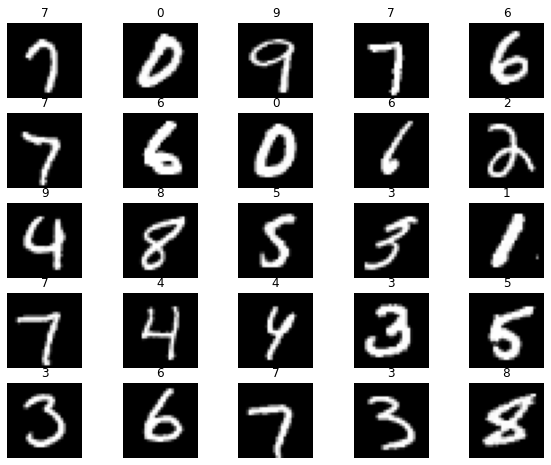

In [7]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 1. (TODO) The CNN Model [15 points]
- Complete the following section to create a CNN model for hand written digit image recognition.
- The model should consist of convolutional layer, the pooling layer and fully connected layer.
- The output should be the categorical distribution over 10 categories (0-9 digit)

In [32]:
class Model(nn.Module):
    """Custom CNN model to recognize the digit on input hand written image"""
    def __init__(self):
        """ Define and instantiate your layers"""
        super(Model, self).__init__()
        # YOUR CODE HERE

        #convolutional layer, activation, max pooling
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),                              
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )

        # fully connected layer
        self.fc = nn.Linear(3136, 10)
        
    def forward(self, x):
        """ 
        Run forward pass on input image X
        
        Args:
            x: torch tensor of input image, 
                with shape of [batch_size * 1 * img_h * img_w]
        
        Return:
            out: torch tensor of predicted categorical distribution  
                on input images, with shape of [batch_size, 10]
         
        """
        # YOUR CODE HERE
        x = self.layers(x)
        x = x.view(x.size(0), -1)       
        output = self.fc(x)
        
        return output

### 2. (TODO) The Training Loop [15 points]
- Instantiate the model and optimizer
- Select proper loss function for this task
- Complete the training loop

In [34]:
device = args.device
print('Using device {}'.format(device))
cnn = Model()
cnn = cnn.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=args.lr)

def train(num_epochs, cnn):
   # YOUR CODE HERE
    for e in range(num_epochs):
        cnn.train()
        for t, (x, y) in enumerate(mnist_train_loader):
            x = x.to(device)
            y = y.to(device)
            y_pred = cnn(x)
            loss = loss_func(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % 100 == 0:
                print('epoch {}, iteration {}, loss = {}'.format(e, t, loss.item()))

train(args.epochs, cnn)

Using device cpu
epoch 0, iteration 0, loss = 2.3335204124450684
epoch 0, iteration 100, loss = 0.8340717554092407
epoch 0, iteration 200, loss = 0.7337744832038879
epoch 0, iteration 300, loss = 0.5120140314102173
epoch 0, iteration 400, loss = 0.1748100221157074
epoch 0, iteration 500, loss = 0.35030120611190796
epoch 0, iteration 600, loss = 0.46747273206710815
epoch 0, iteration 700, loss = 0.18451635539531708
epoch 0, iteration 800, loss = 0.15133829414844513
epoch 0, iteration 900, loss = 0.26336386799812317
epoch 0, iteration 1000, loss = 0.1899753212928772
epoch 0, iteration 1100, loss = 0.19658246636390686
epoch 1, iteration 0, loss = 0.3255142569541931
epoch 1, iteration 100, loss = 0.2066698968410492
epoch 1, iteration 200, loss = 0.21452277898788452
epoch 1, iteration 300, loss = 0.28116318583488464
epoch 1, iteration 400, loss = 0.18815216422080994
epoch 1, iteration 500, loss = 0.30332934856414795
epoch 1, iteration 600, loss = 0.19381074607372284
epoch 1, iteration 700, 

In [35]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in mnist_test_loader:
            #test_output, last_layer = cnn(images.to(device))
            test_output = cnn(images.to(device))
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels.to(device)).sum().item()
            total += labels.size(0)
    print('Test Accuracy of the model on the 10000 test images: %.2f %%' % (correct*100.0/total))
test()
    

Test Accuracy of the model on the 10000 test images: 96.24 %
